# Charaland Price Prediction - Clean Notebook


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor
import joblib

## Load Dataset

In [2]:
df = pd.read_csv('jabodetabek_house_price.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3553 entries, 0 to 3552
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   url                   3553 non-null   object 
 1   price_in_rp           3553 non-null   float64
 2   title                 3553 non-null   object 
 3   address               3553 non-null   object 
 4   district              3553 non-null   object 
 5   city                  3553 non-null   object 
 6   lat                   3553 non-null   float64
 7   long                  3553 non-null   float64
 8   facilities            3553 non-null   object 
 9   property_type         3552 non-null   object 
 10  ads_id                3549 non-null   object 
 11  bedrooms              3519 non-null   float64
 12  bathrooms             3524 non-null   float64
 13  land_size_m2          3551 non-null   float64
 14  building_size_m2      3551 non-null   float64
 15  carports             

## Data Selection

In [3]:
dropped_df = df.drop(['url', 'title', 'address', 'district', 'city', 'ads_id', 'year_built', 'building_orientation', 'building_age'], axis=1)
dropped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3553 entries, 0 to 3552
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price_in_rp         3553 non-null   float64
 1   lat                 3553 non-null   float64
 2   long                3553 non-null   float64
 3   facilities          3553 non-null   object 
 4   property_type       3552 non-null   object 
 5   bedrooms            3519 non-null   float64
 6   bathrooms           3524 non-null   float64
 7   land_size_m2        3551 non-null   float64
 8   building_size_m2    3551 non-null   float64
 9   carports            3553 non-null   float64
 10  certificate         3412 non-null   object 
 11  electricity         3553 non-null   object 
 12  maid_bedrooms       3553 non-null   float64
 13  maid_bathrooms      3553 non-null   float64
 14  floors              3547 non-null   float64
 15  property_condition  3307 non-null   object 
 16  garage

## Data Creation

In [4]:
dropped_df['total_bedroom'] = dropped_df['bedrooms'] +  dropped_df['maid_bedrooms']
dropped_df['total_bedroom']

dropped_df['total_bathroom'] = dropped_df['bathrooms'] +  dropped_df['maid_bathrooms']
dropped_df['total_bathroom']
dropped_df.drop(['bedrooms', 'maid_bedrooms', 'bathrooms', 'maid_bathrooms'], axis=1, inplace=True)

## EXPLANATORY DATA ANALYSIS

## Handle Missing Data

In [5]:
dropped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3553 entries, 0 to 3552
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price_in_rp         3553 non-null   float64
 1   lat                 3553 non-null   float64
 2   long                3553 non-null   float64
 3   facilities          3553 non-null   object 
 4   property_type       3552 non-null   object 
 5   land_size_m2        3551 non-null   float64
 6   building_size_m2    3551 non-null   float64
 7   carports            3553 non-null   float64
 8   certificate         3412 non-null   object 
 9   electricity         3553 non-null   object 
 10  floors              3547 non-null   float64
 11  property_condition  3307 non-null   object 
 12  garages             3553 non-null   float64
 13  furnishing          3166 non-null   object 
 14  total_bedroom       3519 non-null   float64
 15  total_bathroom      3524 non-null   float64
dtypes: flo

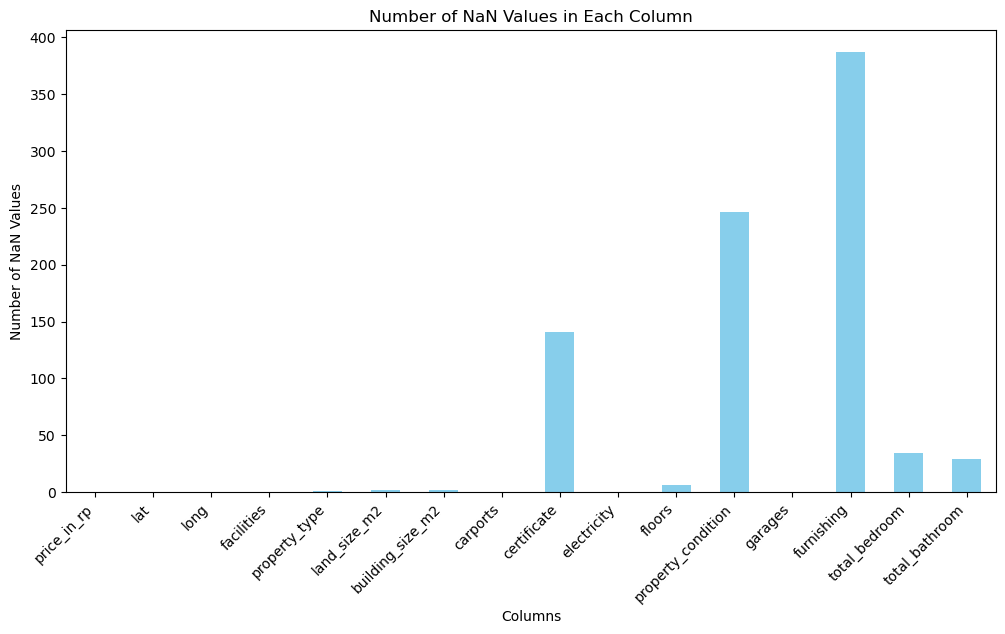

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Count the number of NaN values in each column
nan_counts = dropped_df.isnull().sum()

# Plot the number of NaN values for each column
plt.figure(figsize=(12, 6))
nan_counts.plot(kind='bar', color='skyblue')
plt.title('Number of NaN Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.xticks(rotation=45, ha='right')
plt.show()

## Drop Cols with Less NaN Value

In [7]:
less_nan = dropped_df[dropped_df['total_bathroom'].isna() | dropped_df['total_bedroom'].isna() | dropped_df['land_size_m2'].isna() | dropped_df['building_size_m2'].isna()]
less_nan

,price_in_rp,lat,long,facilities,property_type,land_size_m2,building_size_m2,carports,certificate,electricity,floors,property_condition,garages,furnishing,total_bedroom,total_bathroom
8,2.900000e+09,-6.223945,106.986275,Kitchen Set,rumah,200.0,152.0,2.0,shm - sertifikat hak milik,4400 mah,2.0,NaN,0.0,semi furnished,NaN,4.0
24,2.000000e+09,-6.223945,106.986275,Jalur Telepon,rumah,164.0,155.0,0.0,shm - sertifikat hak milik,2200 mah,1.0,bagus,0.0,semi furnished,NaN,NaN
60,1.200000e+09,-6.284978,106.970127,"Tempat Jemuran, Ac, Mesin Cuci, Track Lari, ...",rumah,120.0,90.0,2.0,shm - sertifikat hak milik,2200 mah,2.0,baru,0.0,furnished,NaN,2.0
110,7.790000e+08,-6.181752,106.973684,"Lapangan Bulu Tangkis, Track Lari, One Gate S...",rumah,63.0,53.0,0.0,shm - sertifikat hak milik,2200 mah,1.0,baru,0.0,NaN,NaN,NaN
131,2.170000e+09,-6.181752,106.973684,"Keamanan 24 jam, Keamanan, One Gate System, K...",rumah,144.0,121.0,0.0,shm - sertifikat hak milik,2200 mah,1.0,bagus,0.0,NaN,NaN,NaN
409,3.750000e+08,-6.242993,107.018010,"Akses Parkir, Keamanan 24 jam, Taman",rumah,60.0,60.0,0.0,shm - sertifikat hak milik,900 mah,1.0,butuh renovasi,0.0,NaN,NaN,NaN
441,5.500000e+08,-6.120970,107.000449,Keamanan 24 jam,rumah,120.0,100.0,1.0,shm - sertifikat hak milik,2200 mah,1.0,bagus,0.0,NaN,NaN,NaN
445,3.900000e+08,-6.332815,107.124733,"Track Lari, Akses Parkir, One Gate System, M...",rumah,60.0,36.0,0.0,shm - sertifikat hak milik,1300 mah,1.0,bagus,0.0,NaN,NaN,NaN
491,8.500000e+08,-6.268268,106.970205,"Tempat Jemuran, Kolam Renang, Masjid, Keamana...",rumah,113.0,90.0,2.0,shm - sertifikat hak milik,2200 mah,2.0,baru,0.0,unfurnished,NaN,NaN
497,9.300000e+08,-6.268268,106.970205,"Track Lari, Taman, Kolam Renang, Taman, Joggi...",rumah,60.0,48.0,1.0,shm - sertifikat hak milik,2200 mah,1.0,butuh renovasi,0.0,unfurnished,3.0,NaN


In [8]:
dropped_less = dropped_df.drop(less_nan.index, axis=0)
dropped_less.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3514 entries, 0 to 3552
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price_in_rp         3514 non-null   float64
 1   lat                 3514 non-null   float64
 2   long                3514 non-null   float64
 3   facilities          3514 non-null   object 
 4   property_type       3514 non-null   object 
 5   land_size_m2        3514 non-null   float64
 6   building_size_m2    3514 non-null   float64
 7   carports            3514 non-null   float64
 8   certificate         3374 non-null   object 
 9   electricity         3514 non-null   object 
 10  floors              3510 non-null   float64
 11  property_condition  3275 non-null   object 
 12  garages             3514 non-null   float64
 13  furnishing          3144 non-null   object 
 14  total_bedroom       3514 non-null   float64
 15  total_bathroom      3514 non-null   float64
dtypes: float64(

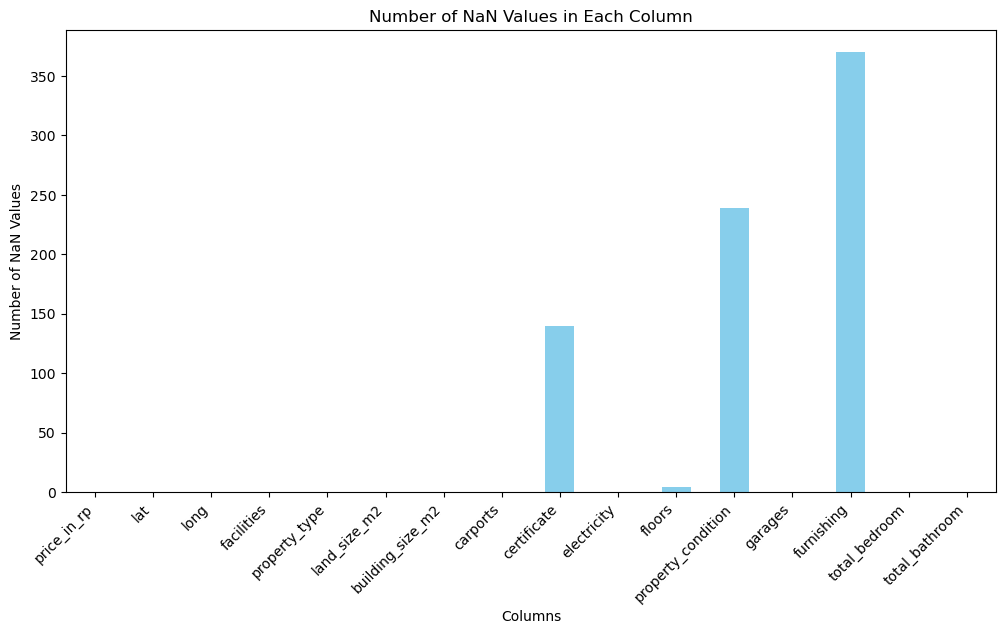

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Count the number of NaN values in each column
nan_counts = dropped_less.isnull().sum()

# Plot the number of NaN values for each column
plt.figure(figsize=(12, 6))
nan_counts.plot(kind='bar', color='skyblue')
plt.title('Number of NaN Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.xticks(rotation=45, ha='right')
plt.show()

## Handle Certificate

In [10]:
# Assume all NaN certificate is 'lainnya'
filled_certif = dropped_less.copy()
filled_certif['certificate'] = filled_certif['certificate'].fillna('lainnya (ppjb,girik,adat,dll)')
filled_certif

,price_in_rp,lat,long,facilities,property_type,land_size_m2,building_size_m2,carports,certificate,electricity,floors,property_condition,garages,furnishing,total_bedroom,total_bathroom
0,2.990000e+09,-6.223945,106.986275,"Tempat Jemuran, Jalur Telepon, Taman, Taman",rumah,239.0,272.0,0.0,shm - sertifikat hak milik,4400 mah,2.0,bagus,0.0,unfurnished,4.0,5.0
1,1.270000e+09,-6.223945,106.986275,Taman,rumah,55.0,69.0,1.0,hgb - hak guna bangunan,2200 mah,2.0,bagus,0.0,NaN,3.0,2.0
2,1.950000e+09,-6.223945,106.986275,"Jogging Track, Kolam Renang, Masjid, Taman,...",rumah,119.0,131.0,1.0,hgb - hak guna bangunan,2200 mah,2.0,bagus,1.0,unfurnished,4.0,4.0
3,3.300000e+09,-6.223945,106.986275,"Jalur Telepon, Jogging Track, Track Lari, K...",rumah,180.0,174.0,0.0,shm - sertifikat hak milik,3500 mah,2.0,bagus sekali,2.0,unfurnished,4.0,4.0
4,4.500000e+09,-6.223945,106.986275,"Jogging Track, Kolam Renang, Taman, Jalur Te...",rumah,328.0,196.0,2.0,shm - sertifikat hak milik,3500 mah,2.0,bagus,1.0,unfurnished,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3548,5.880000e+08,-6.296615,106.704601,"Masjid, Taman, Tempat Jemuran, Keamanan 24 ja...",rumah,72.0,36.0,1.0,shm - sertifikat hak milik,1300 mah,1.0,baru,1.0,furnished,2.0,1.0
3549,7.850000e+08,-6.283454,106.638775,"Masjid, Keamanan, Jogging Track, Taman, Tem...",rumah,85.0,60.0,1.0,shm - sertifikat hak milik,1300 mah,2.0,baru,0.0,unfurnished,3.0,2.0
3550,7.550000e+08,-6.283454,106.638775,"Keamanan, Taman, Jogging Track, Tempat Jemur...",rumah,78.0,60.0,1.0,shm - sertifikat hak milik,1300 mah,2.0,baru,0.0,unfurnished,3.0,2.0
3551,8.000000e+08,-6.288237,106.665859,"Tempat Jemuran, Keamanan, Keamanan 24 jam, Was...",rumah,60.0,65.0,2.0,shm - sertifikat hak milik,2200 mah,2.0,baru,0.0,furnished,3.0,2.0


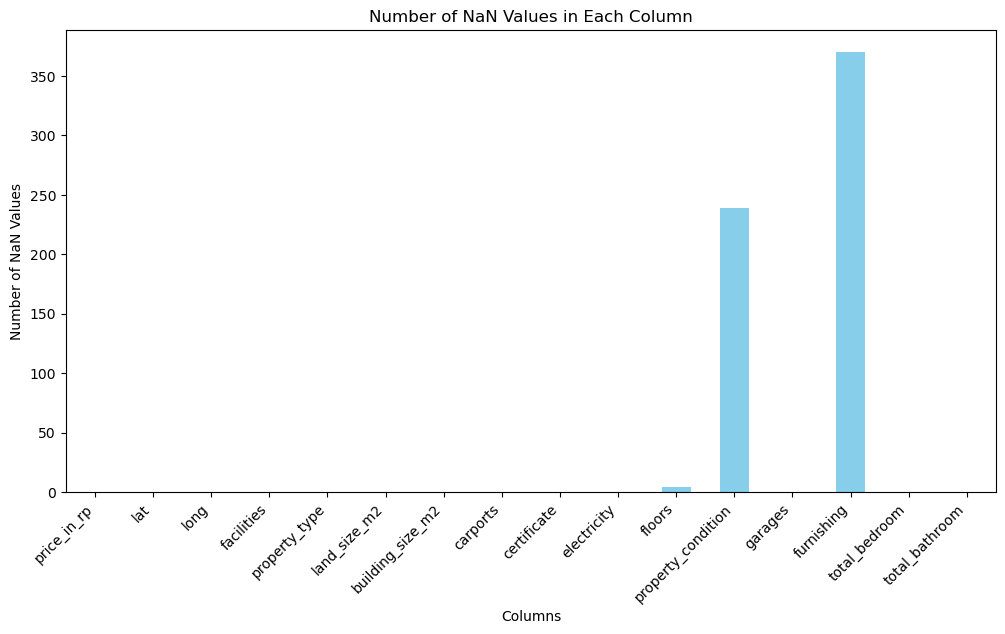

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Count the number of NaN values in each column
nan_counts = filled_certif.isnull().sum()

# Plot the number of NaN values for each column
plt.figure(figsize=(12, 6))
nan_counts.plot(kind='bar', color='skyblue')
plt.title('Number of NaN Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.xticks(rotation=45, ha='right')
plt.show()

## Handle Property Condition and Furnishing

In [12]:
filled_certif['property_condition'].value_counts()

property_condition
bagus             1425
baru              1317
bagus sekali       261
sudah renovasi     155
butuh renovasi      88
unfurnished         25
semi furnished       4
Name: count, dtype: int64

In [13]:
filled_certif['furnishing'].value_counts()

furnishing
unfurnished       2052
semi furnished     826
furnished          237
baru                29
Name: count, dtype: int64

In [14]:
swapped_col = dropped_df[dropped_df['furnishing'] == 'baru'][['property_condition', 'furnishing']]
swapped_col

,property_condition,furnishing
274,semi furnished,baru
275,semi furnished,baru
276,semi furnished,baru
1504,unfurnished,baru
1505,unfurnished,baru
1506,unfurnished,baru
1554,unfurnished,baru
1555,unfurnished,baru
1556,unfurnished,baru
1557,unfurnished,baru


In [15]:
filled_certif.loc[swapped_col.index, ['property_condition', 'furnishing']] = filled_certif.loc[swapped_col.index, ['furnishing', 'property_condition']].to_numpy()

In [16]:
filled_certif['property_condition'].value_counts()

property_condition
bagus             1425
baru              1346
bagus sekali       261
sudah renovasi     155
butuh renovasi      88
Name: count, dtype: int64

In [17]:
filled_certif['furnishing'].value_counts()

furnishing
unfurnished       2077
semi furnished     830
furnished          237
Name: count, dtype: int64

In [18]:
#Assume most houses are similar
filled_house = filled_certif.copy()
filled_house['property_condition'] = filled_house['property_condition'].fillna(filled_certif['property_condition'].mode().iloc[0])
filled_house['furnishing'] = filled_house['furnishing'].fillna(filled_certif['furnishing'].mode().iloc[0])

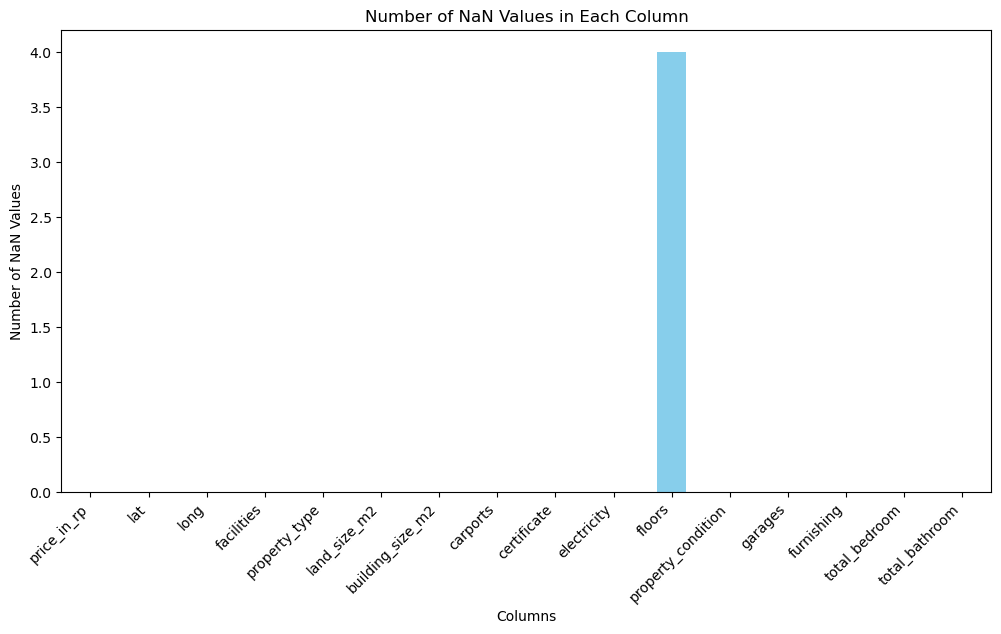

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Count the number of NaN values in each column
nan_counts = filled_house.isnull().sum()

# Plot the number of NaN values for each column
plt.figure(figsize=(12, 6))
nan_counts.plot(kind='bar', color='skyblue')
plt.title('Number of NaN Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.xticks(rotation=45, ha='right')
plt.show()

## Check Corelation

In [20]:
y = filled_house[filled_house['electricity'] == 'lainnya mah']

clean_elec = filled_house.drop(y.index, axis=0)

clean_elec['electricity'].unique()

array(['4400 mah', '2200 mah', '3500 mah', '1300 mah', '5500 mah',
       '6600 mah', '7700 mah', '3300 mah', '7600 mah', '10600 mah',
       '900 mah', '47500 mah', '11000 mah', '8000 mah', '450 mah',
       '10000 mah', '53000 mah', '16500 mah', '13200 mah', '13900 mah',
       '17600 mah', '23000 mah', '41500 mah', '12700 mah', '13300 mah',
       '33000 mah', '24000 mah', '22000 mah', '9500 mah'], dtype=object)

In [21]:
clean_elec['electricity'] = clean_elec['electricity'].apply(lambda x: int(x.split()[0]))

<Axes: >

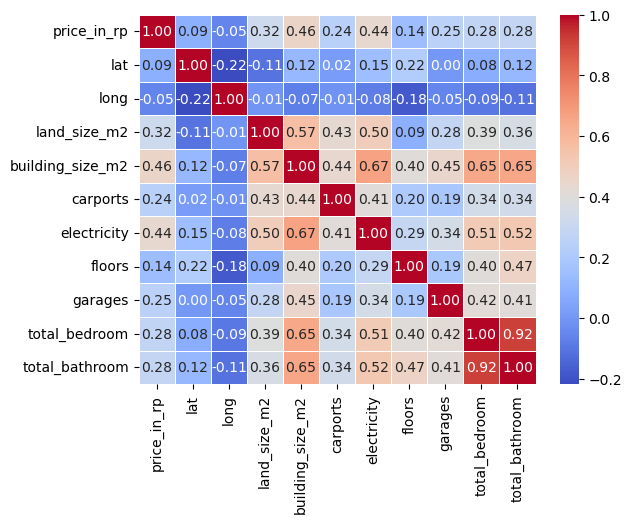

In [22]:
cat_col = [col for col in clean_elec.columns if clean_elec[col].dtype == 'object']
num_col = [col for col in clean_elec.columns if clean_elec[col].dtype != 'object']


num_clean_elec = clean_elec[num_col]
sns.heatmap(num_clean_elec.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)

## Floor has some high correlation with other column

In [23]:
not_nan_floor = filled_house[filled_house['floors'].notna()]
nan_floor = filled_house[filled_house['floors'].isna()]

related_col_floor =   ['building_size_m2', 'total_bedroom', 'total_bathroom', 'floors']
not_nan_floor = not_nan_floor[related_col_floor]

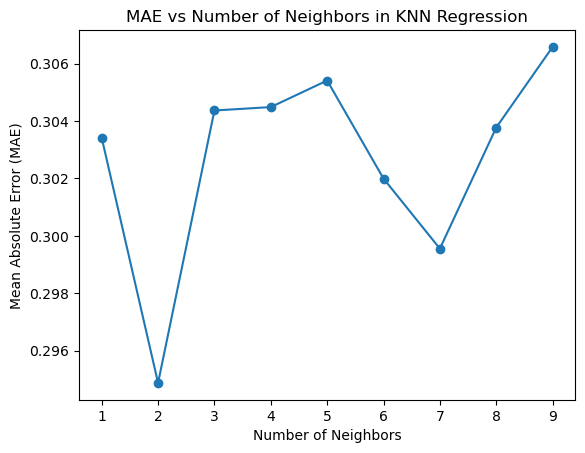

In [24]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor

# Assuming 'target_column' is your target variable
X = not_nan_floor.drop('floors', axis=1)
y =  not_nan_floor['floors']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lists to store results
neighbors = list(range(1, 10))
mae_values = []

for i in neighbors:
    # Initialize KNN regressor
    knn_regressor = KNeighborsRegressor(n_neighbors=i)

    # Train the model
    knn_regressor.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = knn_regressor.predict(X_test)

    # Evaluate the model using Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, predictions)
    mae_values.append(mae)

# Plotting the MAE values against the number of neighbors
plt.plot(neighbors, mae_values, marker='o')
plt.title('MAE vs Number of Neighbors in KNN Regression')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Absolute Error (MAE)')
plt.show()


In [25]:
from sklearn.neighbors import KNeighborsRegressor

# Assuming 'target_column' is your target variable
X = not_nan_floor.drop('floors', axis=1)
y = not_nan_floor['floors']

# Filter rows with missing electricity values
nan_floor = filled_house[filled_house['floors'].isna()][related_col_floor]
X_missing = nan_floor.copy()

X_missing.drop('floors', axis=1, inplace=True)

# Initialize KNN regressor
final_k_neigh = KNeighborsRegressor(n_neighbors=1)

# Train the model
final_k_neigh.fit(X, y)

# Predict missing values
predictions = final_k_neigh.predict(X_missing)

# Round the predictions
rounded_predictions = [round(pred) for pred in predictions]

filled_floors = filled_house.copy()
# Update the missing 'electricity' values in dropped_df
filled_floors.loc[nan_floor.index, 'floors'] = rounded_predictions

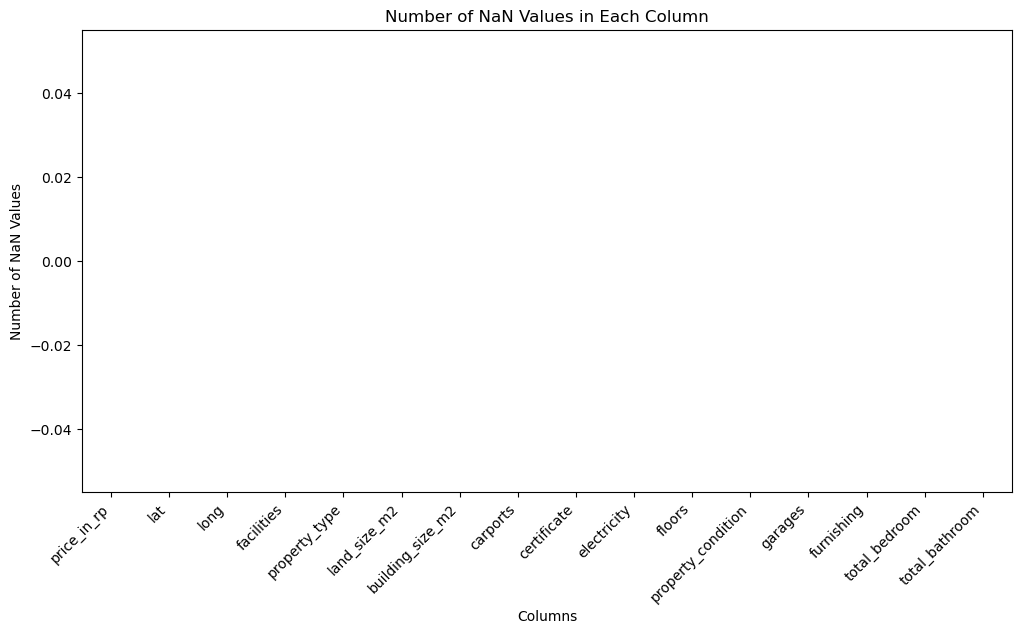

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Count the number of NaN values in each column
nan_counts = filled_floors.isnull().sum()

# Plot the number of NaN values for each column
plt.figure(figsize=(12, 6))
nan_counts.plot(kind='bar', color='skyblue')
plt.title('Number of NaN Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.xticks(rotation=45, ha='right')
plt.show()

In [27]:
y = filled_floors[filled_floors['electricity'] == 'lainnya mah']

clean_elec = filled_floors.drop(y.index, axis=0)

clean_elec['electricity'].unique()

array(['4400 mah', '2200 mah', '3500 mah', '1300 mah', '5500 mah',
       '6600 mah', '7700 mah', '3300 mah', '7600 mah', '10600 mah',
       '900 mah', '47500 mah', '11000 mah', '8000 mah', '450 mah',
       '10000 mah', '53000 mah', '16500 mah', '13200 mah', '13900 mah',
       '17600 mah', '23000 mah', '41500 mah', '12700 mah', '13300 mah',
       '33000 mah', '24000 mah', '22000 mah', '9500 mah'], dtype=object)

In [28]:
clean_elec['electricity'] = clean_elec['electricity'].apply(lambda x: int(x.split()[0]))

In [29]:
related_col_elec =  ['building_size_m2', 'land_size_m2', 'total_bedroom', 'total_bathroom', 'floors', 'electricity']
clean_elec = clean_elec[related_col_elec]

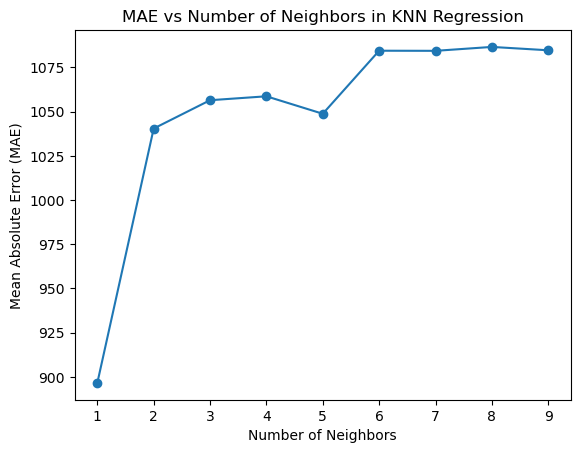

In [30]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor

# Assuming 'target_column' is your target variable
X = clean_elec.drop('electricity', axis=1)
y =  clean_elec['electricity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lists to store results
neighbors = list(range(1, 10))
mae_values = []

for i in neighbors:
    # Initialize KNN regressor
    knn_regressor = KNeighborsRegressor(n_neighbors=i)

    # Train the model
    knn_regressor.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = knn_regressor.predict(X_test)

    # Evaluate the model using Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, predictions)
    mae_values.append(mae)

# Plotting the MAE values against the number of neighbors
plt.plot(neighbors, mae_values, marker='o')
plt.title('MAE vs Number of Neighbors in KNN Regression')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Absolute Error (MAE)')
plt.show()

In [31]:
from sklearn.neighbors import KNeighborsRegressor

# Assuming 'target_column' is your target variable
X = clean_elec[related_col_elec].drop('electricity', axis=1) 
y = clean_elec['electricity']

# Filter rows with missing electricity values
missing_values = filled_floors[filled_floors['electricity'] == 'lainnya mah']
X_missing = missing_values[related_col_elec].copy()

X_missing.drop('electricity', axis=1, inplace=True)

# Initialize KNN regressor
final_k_neigh = KNeighborsRegressor(n_neighbors=1)

# Train the model
final_k_neigh.fit(X, y)

# Predict missing values
predictions = final_k_neigh.predict(X_missing)

# Round the predictions
rounded_predictions = [round(pred) for pred in predictions]

# Update the missing 'electricity' values in dropped_df
filled_elec = filled_floors.copy()
filled_elec.loc[missing_values.index, 'electricity'] = predictions

In [32]:
filled_elec.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3514 entries, 0 to 3552
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price_in_rp         3514 non-null   float64
 1   lat                 3514 non-null   float64
 2   long                3514 non-null   float64
 3   facilities          3514 non-null   object 
 4   property_type       3514 non-null   object 
 5   land_size_m2        3514 non-null   float64
 6   building_size_m2    3514 non-null   float64
 7   carports            3514 non-null   float64
 8   certificate         3514 non-null   object 
 9   electricity         3514 non-null   object 
 10  floors              3514 non-null   float64
 11  property_condition  3514 non-null   object 
 12  garages             3514 non-null   float64
 13  furnishing          3514 non-null   object 
 14  total_bedroom       3514 non-null   float64
 15  total_bathroom      3514 non-null   float64
dtypes: float64(

In [33]:
filled_elec['facilities']

0            Tempat Jemuran, Jalur Telepon, Taman,  Taman
1                                                   Taman
2        Jogging Track,  Kolam Renang, Masjid,  Taman,...
3        Jalur Telepon,  Jogging Track, Track Lari,  K...
4        Jogging Track,  Kolam Renang, Taman, Jalur Te...
                              ...                        
3548    Masjid,  Taman, Tempat Jemuran, Keamanan 24 ja...
3549    Masjid,  Keamanan,  Jogging Track,  Taman, Tem...
3550     Keamanan,  Taman, Jogging Track, Tempat Jemur...
3551    Tempat Jemuran, Keamanan, Keamanan 24 jam, Was...
3552    Kulkas, Masjid,  Taman, Lapangan Bola, Tempat ...
Name: facilities, Length: 3514, dtype: object

## Encoding Categorial Value

In [34]:
encode_col = filled_elec.copy()
cat_col = [col for col in encode_col.columns if encode_col[col].dtype == 'object']
cat_col

['facilities',
 'property_type',
 'certificate',
 'electricity',
 'property_condition',
 'furnishing']

In [35]:
for column in cat_col:
    print(f"Unique values in {column}:\n{encode_col[column].unique()}\n")

Unique values in facilities:
['Tempat Jemuran, Jalur Telepon, Taman,  Taman' 'Taman'
 ' Jogging Track,  Kolam Renang, Masjid,  Taman, Jalur Telepon,  Keamanan'
 ...
 ' Taman, Tempat Jemuran, Jalur Telepon, One Gate System, Keamanan 24 jam, AC, Wastafel,  Playground'
 'Masjid,  Taman, Tempat Jemuran, Keamanan 24 jam, AC, Wastafel,  CCTV, Track Lari, Taman,  One Gate System'
 'Masjid,  Keamanan,  Jogging Track,  Taman, Tempat Jemuran, Jalur Telepon, Keamanan 24 jam,  Masjid, Track Lari, Taman,  One Gate System']

Unique values in property_type:
['rumah']

Unique values in certificate:
['shm - sertifikat hak milik' 'hgb - hak guna bangunan'
 'lainnya (ppjb,girik,adat,dll)' 'hp - hak pakai']

Unique values in electricity:
['4400 mah' '2200 mah' '3500 mah' '1300 mah' 1300.0 '5500 mah' 2200.0
 '6600 mah' '7700 mah' '3300 mah' 4400.0 '7600 mah' '10600 mah' '900 mah'
 '47500 mah' '11000 mah' '8000 mah' 11000.0 '450 mah' 3500.0 5500.0
 16500.0 3300.0 6600.0 '10000 mah' 12700.0 7600.0 7700.0 '53

## Handle Electricity

In [36]:
encode_col['electricity'].unique()

array(['4400 mah', '2200 mah', '3500 mah', '1300 mah', 1300.0, '5500 mah',
       2200.0, '6600 mah', '7700 mah', '3300 mah', 4400.0, '7600 mah',
       '10600 mah', '900 mah', '47500 mah', '11000 mah', '8000 mah',
       11000.0, '450 mah', 3500.0, 5500.0, 16500.0, 3300.0, 6600.0,
       '10000 mah', 12700.0, 7600.0, 7700.0, '53000 mah', 10000.0,
       33000.0, '16500 mah', 10600.0, '13200 mah', 13900.0, '13900 mah',
       '17600 mah', '23000 mah', '41500 mah', '12700 mah', '13300 mah',
       '33000 mah', '24000 mah', '22000 mah', 13200.0, '9500 mah',
       53000.0], dtype=object)

In [37]:
encode_col['electricity'] = encode_col['electricity'].apply(lambda x: int(x.split()[0]) if isinstance(x, str) else float(x))

In [38]:
encode_col.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3514 entries, 0 to 3552
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price_in_rp         3514 non-null   float64
 1   lat                 3514 non-null   float64
 2   long                3514 non-null   float64
 3   facilities          3514 non-null   object 
 4   property_type       3514 non-null   object 
 5   land_size_m2        3514 non-null   float64
 6   building_size_m2    3514 non-null   float64
 7   carports            3514 non-null   float64
 8   certificate         3514 non-null   object 
 9   electricity         3514 non-null   float64
 10  floors              3514 non-null   float64
 11  property_condition  3514 non-null   object 
 12  garages             3514 non-null   float64
 13  furnishing          3514 non-null   object 
 14  total_bedroom       3514 non-null   float64
 15  total_bathroom      3514 non-null   float64
dtypes: float64(

## Encode Property Condition

In [39]:
encode_col['property_condition'].unique()

array(['bagus', 'bagus sekali', 'baru', 'sudah renovasi',
       'butuh renovasi'], dtype=object)

In [40]:
from sklearn.preprocessing import OrdinalEncoder

property_condition_column = encode_col[['property_condition']]

category_order = ['butuh renovasi', 'sudah renovasi', 'baru', 'bagus',  'bagus sekali']

encoder = OrdinalEncoder(categories=[category_order], dtype=int)

encoded_property_condition = encoder.fit_transform(property_condition_column)

encode_col['en_property_condition'] = encoded_property_condition

encode_col

,price_in_rp,lat,long,facilities,property_type,land_size_m2,building_size_m2,carports,certificate,electricity,floors,property_condition,garages,furnishing,total_bedroom,total_bathroom,en_property_condition
0,2.990000e+09,-6.223945,106.986275,"Tempat Jemuran, Jalur Telepon, Taman, Taman",rumah,239.0,272.0,0.0,shm - sertifikat hak milik,4400.0,2.0,bagus,0.0,unfurnished,4.0,5.0,3
1,1.270000e+09,-6.223945,106.986275,Taman,rumah,55.0,69.0,1.0,hgb - hak guna bangunan,2200.0,2.0,bagus,0.0,unfurnished,3.0,2.0,3
2,1.950000e+09,-6.223945,106.986275,"Jogging Track, Kolam Renang, Masjid, Taman,...",rumah,119.0,131.0,1.0,hgb - hak guna bangunan,2200.0,2.0,bagus,1.0,unfurnished,4.0,4.0,3
3,3.300000e+09,-6.223945,106.986275,"Jalur Telepon, Jogging Track, Track Lari, K...",rumah,180.0,174.0,0.0,shm - sertifikat hak milik,3500.0,2.0,bagus sekali,2.0,unfurnished,4.0,4.0,4
4,4.500000e+09,-6.223945,106.986275,"Jogging Track, Kolam Renang, Taman, Jalur Te...",rumah,328.0,196.0,2.0,shm - sertifikat hak milik,3500.0,2.0,bagus,1.0,unfurnished,5.0,4.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3548,5.880000e+08,-6.296615,106.704601,"Masjid, Taman, Tempat Jemuran, Keamanan 24 ja...",rumah,72.0,36.0,1.0,shm - sertifikat hak milik,1300.0,1.0,baru,1.0,furnished,2.0,1.0,2
3549,7.850000e+08,-6.283454,106.638775,"Masjid, Keamanan, Jogging Track, Taman, Tem...",rumah,85.0,60.0,1.0,shm - sertifikat hak milik,1300.0,2.0,baru,0.0,unfurnished,3.0,2.0,2
3550,7.550000e+08,-6.283454,106.638775,"Keamanan, Taman, Jogging Track, Tempat Jemur...",rumah,78.0,60.0,1.0,shm - sertifikat hak milik,1300.0,2.0,baru,0.0,unfurnished,3.0,2.0,2
3551,8.000000e+08,-6.288237,106.665859,"Tempat Jemuran, Keamanan, Keamanan 24 jam, Was...",rumah,60.0,65.0,2.0,shm - sertifikat hak milik,2200.0,2.0,baru,0.0,furnished,3.0,2.0,2


## Encode Furnishing

In [41]:
from sklearn.preprocessing import OrdinalEncoder

# Extract the 'furnishing' column as a 2D array (required by OrdinalEncoder)
furnishing_column = encode_col[['furnishing']]

# Define the order of categories
category_order = [ 'unfurnished', 'semi furnished',  'furnished']

# Create an instance of OrdinalEncoder with the specified order
encoder = OrdinalEncoder(categories=[category_order], dtype=int)

# Fit and transform the 'furnishing' column
encoded_furnishing = encoder.fit_transform(furnishing_column)

# Replace the original 'furnishing' column with the encoded values
encode_col['en_furnishing'] = encoded_furnishing

# Display the updated DataFrame
encode_col

,price_in_rp,lat,long,facilities,property_type,land_size_m2,building_size_m2,carports,certificate,electricity,floors,property_condition,garages,furnishing,total_bedroom,total_bathroom,en_property_condition,en_furnishing
0,2.990000e+09,-6.223945,106.986275,"Tempat Jemuran, Jalur Telepon, Taman, Taman",rumah,239.0,272.0,0.0,shm - sertifikat hak milik,4400.0,2.0,bagus,0.0,unfurnished,4.0,5.0,3,0
1,1.270000e+09,-6.223945,106.986275,Taman,rumah,55.0,69.0,1.0,hgb - hak guna bangunan,2200.0,2.0,bagus,0.0,unfurnished,3.0,2.0,3,0
2,1.950000e+09,-6.223945,106.986275,"Jogging Track, Kolam Renang, Masjid, Taman,...",rumah,119.0,131.0,1.0,hgb - hak guna bangunan,2200.0,2.0,bagus,1.0,unfurnished,4.0,4.0,3,0
3,3.300000e+09,-6.223945,106.986275,"Jalur Telepon, Jogging Track, Track Lari, K...",rumah,180.0,174.0,0.0,shm - sertifikat hak milik,3500.0,2.0,bagus sekali,2.0,unfurnished,4.0,4.0,4,0
4,4.500000e+09,-6.223945,106.986275,"Jogging Track, Kolam Renang, Taman, Jalur Te...",rumah,328.0,196.0,2.0,shm - sertifikat hak milik,3500.0,2.0,bagus,1.0,unfurnished,5.0,4.0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3548,5.880000e+08,-6.296615,106.704601,"Masjid, Taman, Tempat Jemuran, Keamanan 24 ja...",rumah,72.0,36.0,1.0,shm - sertifikat hak milik,1300.0,1.0,baru,1.0,furnished,2.0,1.0,2,2
3549,7.850000e+08,-6.283454,106.638775,"Masjid, Keamanan, Jogging Track, Taman, Tem...",rumah,85.0,60.0,1.0,shm - sertifikat hak milik,1300.0,2.0,baru,0.0,unfurnished,3.0,2.0,2,0
3550,7.550000e+08,-6.283454,106.638775,"Keamanan, Taman, Jogging Track, Tempat Jemur...",rumah,78.0,60.0,1.0,shm - sertifikat hak milik,1300.0,2.0,baru,0.0,unfurnished,3.0,2.0,2,0
3551,8.000000e+08,-6.288237,106.665859,"Tempat Jemuran, Keamanan, Keamanan 24 jam, Was...",rumah,60.0,65.0,2.0,shm - sertifikat hak milik,2200.0,2.0,baru,0.0,furnished,3.0,2.0,2,2


## Drop Property Type

In [42]:
encode_col.drop('property_type', axis=1, inplace=True)

## Encode Certificate

In [43]:
encode_col['certificate'].unique()

array(['shm - sertifikat hak milik', 'hgb - hak guna bangunan',
       'lainnya (ppjb,girik,adat,dll)', 'hp - hak pakai'], dtype=object)

In [44]:
from sklearn.preprocessing import OrdinalEncoder

# Extract the 'certificate' column as a 2D array (required by OrdinalEncoder)
certificate_column = encode_col[['certificate']]

# Define the order of categories
category_order = ['lainnya (ppjb,girik,adat,dll)', 'hp - hak pakai', 'hgb - hak guna bangunan', 
       'shm - sertifikat hak milik']

# Create an instance of OrdinalEncoder with the specified order
encoder = OrdinalEncoder(categories=[category_order], dtype=int)

# Fit and transform the 'certificate' column
encoded_certificate = encoder.fit_transform(certificate_column)

# Replace the original 'certificate' column with the encoded values
encode_col['en_certificate'] = encoded_certificate

# Display the updated DataFrame
encode_col


,price_in_rp,lat,long,facilities,land_size_m2,building_size_m2,carports,certificate,electricity,floors,property_condition,garages,furnishing,total_bedroom,total_bathroom,en_property_condition,en_furnishing,en_certificate
0,2.990000e+09,-6.223945,106.986275,"Tempat Jemuran, Jalur Telepon, Taman, Taman",239.0,272.0,0.0,shm - sertifikat hak milik,4400.0,2.0,bagus,0.0,unfurnished,4.0,5.0,3,0,3
1,1.270000e+09,-6.223945,106.986275,Taman,55.0,69.0,1.0,hgb - hak guna bangunan,2200.0,2.0,bagus,0.0,unfurnished,3.0,2.0,3,0,2
2,1.950000e+09,-6.223945,106.986275,"Jogging Track, Kolam Renang, Masjid, Taman,...",119.0,131.0,1.0,hgb - hak guna bangunan,2200.0,2.0,bagus,1.0,unfurnished,4.0,4.0,3,0,2
3,3.300000e+09,-6.223945,106.986275,"Jalur Telepon, Jogging Track, Track Lari, K...",180.0,174.0,0.0,shm - sertifikat hak milik,3500.0,2.0,bagus sekali,2.0,unfurnished,4.0,4.0,4,0,3
4,4.500000e+09,-6.223945,106.986275,"Jogging Track, Kolam Renang, Taman, Jalur Te...",328.0,196.0,2.0,shm - sertifikat hak milik,3500.0,2.0,bagus,1.0,unfurnished,5.0,4.0,3,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3548,5.880000e+08,-6.296615,106.704601,"Masjid, Taman, Tempat Jemuran, Keamanan 24 ja...",72.0,36.0,1.0,shm - sertifikat hak milik,1300.0,1.0,baru,1.0,furnished,2.0,1.0,2,2,3
3549,7.850000e+08,-6.283454,106.638775,"Masjid, Keamanan, Jogging Track, Taman, Tem...",85.0,60.0,1.0,shm - sertifikat hak milik,1300.0,2.0,baru,0.0,unfurnished,3.0,2.0,2,0,3
3550,7.550000e+08,-6.283454,106.638775,"Keamanan, Taman, Jogging Track, Tempat Jemur...",78.0,60.0,1.0,shm - sertifikat hak milik,1300.0,2.0,baru,0.0,unfurnished,3.0,2.0,2,0,3
3551,8.000000e+08,-6.288237,106.665859,"Tempat Jemuran, Keamanan, Keamanan 24 jam, Was...",60.0,65.0,2.0,shm - sertifikat hak milik,2200.0,2.0,baru,0.0,furnished,3.0,2.0,2,2,3


In [45]:
encode_col['facilities']

0            Tempat Jemuran, Jalur Telepon, Taman,  Taman
1                                                   Taman
2        Jogging Track,  Kolam Renang, Masjid,  Taman,...
3        Jalur Telepon,  Jogging Track, Track Lari,  K...
4        Jogging Track,  Kolam Renang, Taman, Jalur Te...
                              ...                        
3548    Masjid,  Taman, Tempat Jemuran, Keamanan 24 ja...
3549    Masjid,  Keamanan,  Jogging Track,  Taman, Tem...
3550     Keamanan,  Taman, Jogging Track, Tempat Jemur...
3551    Tempat Jemuran, Keamanan, Keamanan 24 jam, Was...
3552    Kulkas, Masjid,  Taman, Lapangan Bola, Tempat ...
Name: facilities, Length: 3514, dtype: object

## Encode Facilities

In [46]:
def list_of_facilities(x):
    lst = x.split(',')
    lst = [i.strip().lower() for i in lst if i != '']  # Exclude empty strings
    lst = list(set(lst))
    return lst

encode_col['facilities'] = filled_floors['facilities'].apply(list_of_facilities)

In [47]:
encode_col['facilities']

0                  [tempat jemuran, jalur telepon, taman]
1                                                 [taman]
2       [taman, kolam renang, masjid, jogging track, k...
3       [taman, cctv, track lari, kolam renang, joggin...
4       [taman, kolam renang, jogging track, keamanan,...
                              ...                        
3548    [ac, keamanan 24 jam, taman, one gate system, ...
3549    [keamanan 24 jam, taman, one gate system, trac...
3550    [taman, track lari, tempat jemuran, masjid, jo...
3551    [keamanan 24 jam, taman, one gate system, temp...
3552    [lapangan bola, keamanan 24 jam, ac, taman, la...
Name: facilities, Length: 3514, dtype: object

In [48]:
all_facilities = [facility for facilities_list in encode_col['facilities'] for facility in facilities_list]

unique_facilities = set(all_facilities)

for facility in unique_facilities:
    print(facility)

torrent
track lari
masjid
garasi
one gate sistem
clubhouse
canopy
backyard luas
keamanan 24 jam
service area
taman
full kitchen set
lapangan basket
pagar
carport
mushola
kitchen set (opsional)
tempat gym
ac 2 unit
toren 500 liter
kompor exhaust
torn 650ltr
carport 2 mobil
wastafel
servis area
lapangan tenis
free kitchen set
akses parkir
cctv area
taman luas
lapangan voli
ac
jetpump
tempat jemuran
gudang
swimming pool
smart lock door
kolam renang anak
ac 3 unit
musholla exclusive
securty 24 jam
lapangan bola
kompor
kitchen set
2 unit ac
posisi hoek
tempat laundry
mesin cuci
security 24h
one gate system
1 unit ac
torn air
smart home
jalur telepon
basement
balkon
living room
private pool
security 24jam
void
pompa air wasser dan booster
onegate
kulkas
pemanas air
pool
keamanan
dapur bersih dan kotor
carport 1 mobil
lemari kayu
kolam ikan
cctv
playground
water heater
lapangan bulu tangkis
taman minimalis
jogging track
security24 jam
smarthome
garden
kolam renang
security 24 jam


In [49]:
facility_groups = {
    'Outdoor': ['track lari', 'kolam renang anak', 'backyard luas', 'kolam renang', 'lapangan voli', 'lapangan bola', 'clubhouse', 'lapangan tenis', 'taman', 'taman minimalis', 'masjid',  'taman luas', 'swimming pool', 'lapangan basket', 'jogging track', 'lapangan bulu tangkis', 'servis area', 'service area', 'garden' 'musholla exclusive', 'pool'],
    'Indoor': ['basement', 'tempat gym', 'tempat laundry', 'playground', 'kolam ikan', 'mushola', 'living room', 'private pool', 'akses parkir', 'gudang'],
    'Kitchen': ['dapur bersih dan kotor', 'kitchen set', 'kitchen set (optional)', 'kompor exhaust', 'free kitchen set', 'full kitchen set', 'kompor'],
    'Car-related': ['carport', 'cartport 1 mobil', 'carport 2 mobil', 'garasi'],
    'Security': ['pagar', 'security 24jam', 'keamanan 24 jam', 'cctv area', 'cctv', 'security 24h', 'onegate', 'security 24 jam', 'securty 24 jam', 'security24 jam', 'keamanan',  'one gate sistem'],
    'Utilities': ['tempat jemuran', 'balkon', 'water heater', 'kulkas', '1 unit ac', 'smart home', 'jalur telepon', 'torn air', 'void', 'wastafel', 'pemanas air', 'mesin cuci', 'canopy', '2 unit ac', 'torn 650ltr', 'ac 2 unit', 'toren 500 liter', 'pompa air wasser dan booster', 'smart lock door', 'smarthome', 'ac 3 unit', 'ac', 'jetpump', 'torrent']
}

In [50]:
for i in facility_groups.keys():
    encode_col[i]= 0

In [51]:
encode_col['facilities'][0]

['tempat jemuran', 'jalur telepon', 'taman']

In [52]:
def count_fac(row):
    for item in row['facilities']:
        for key, val in facility_groups.items():
            if item in val:
                row[key] += 1
    return row

encode_col = encode_col.apply(count_fac, axis=1)

encode_col

,price_in_rp,lat,long,facilities,land_size_m2,building_size_m2,carports,certificate,electricity,floors,...,total_bathroom,en_property_condition,en_furnishing,en_certificate,Outdoor,Indoor,Kitchen,Car-related,Security,Utilities
0,2.990000e+09,-6.223945,106.986275,"[tempat jemuran, jalur telepon, taman]",239.0,272.0,0.0,shm - sertifikat hak milik,4400.0,2.0,...,5.0,3,0,3,1,0,0,0,0,2
1,1.270000e+09,-6.223945,106.986275,[taman],55.0,69.0,1.0,hgb - hak guna bangunan,2200.0,2.0,...,2.0,3,0,2,1,0,0,0,0,0
2,1.950000e+09,-6.223945,106.986275,"[taman, kolam renang, masjid, jogging track, k...",119.0,131.0,1.0,hgb - hak guna bangunan,2200.0,2.0,...,4.0,3,0,2,4,0,0,0,1,1
3,3.300000e+09,-6.223945,106.986275,"[taman, cctv, track lari, kolam renang, joggin...",180.0,174.0,0.0,shm - sertifikat hak milik,3500.0,2.0,...,4.0,4,0,3,4,0,0,0,2,1
4,4.500000e+09,-6.223945,106.986275,"[taman, kolam renang, jogging track, keamanan,...",328.0,196.0,2.0,shm - sertifikat hak milik,3500.0,2.0,...,4.0,3,0,3,3,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3548,5.880000e+08,-6.296615,106.704601,"[ac, keamanan 24 jam, taman, one gate system, ...",72.0,36.0,1.0,shm - sertifikat hak milik,1300.0,1.0,...,1.0,2,2,3,3,0,0,0,2,3
3549,7.850000e+08,-6.283454,106.638775,"[keamanan 24 jam, taman, one gate system, trac...",85.0,60.0,1.0,shm - sertifikat hak milik,1300.0,2.0,...,2.0,2,0,3,4,0,0,0,2,2
3550,7.550000e+08,-6.283454,106.638775,"[taman, track lari, tempat jemuran, masjid, jo...",78.0,60.0,1.0,shm - sertifikat hak milik,1300.0,2.0,...,2.0,2,0,3,4,0,0,0,1,2
3551,8.000000e+08,-6.288237,106.665859,"[keamanan 24 jam, taman, one gate system, temp...",60.0,65.0,2.0,shm - sertifikat hak milik,2200.0,2.0,...,2.0,2,2,3,1,0,0,0,2,2


In [53]:
encode_col.loc[3552, 'facilities']

['lapangan bola',
 'keamanan 24 jam',
 'ac',
 'taman',
 'lapangan bulu tangkis',
 'kulkas',
 'akses parkir',
 'one gate system',
 'track lari',
 'tempat jemuran',
 'masjid',
 'playground',
 'wastafel',
 'jalur telepon',
 'tempat laundry']

In [54]:
encode_col.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3514 entries, 0 to 3552
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_in_rp            3514 non-null   float64
 1   lat                    3514 non-null   float64
 2   long                   3514 non-null   float64
 3   facilities             3514 non-null   object 
 4   land_size_m2           3514 non-null   float64
 5   building_size_m2       3514 non-null   float64
 6   carports               3514 non-null   float64
 7   certificate            3514 non-null   object 
 8   electricity            3514 non-null   float64
 9   floors                 3514 non-null   float64
 10  property_condition     3514 non-null   object 
 11  garages                3514 non-null   float64
 12  furnishing             3514 non-null   object 
 13  total_bedroom          3514 non-null   float64
 14  total_bathroom         3514 non-null   float64
 15  en_proper

## Analyze Outlier

In [55]:
train_col = ['facilities', 'property_condition', 'certificate', 'furnishing']
clean_df = encode_col.drop(train_col, axis=1)

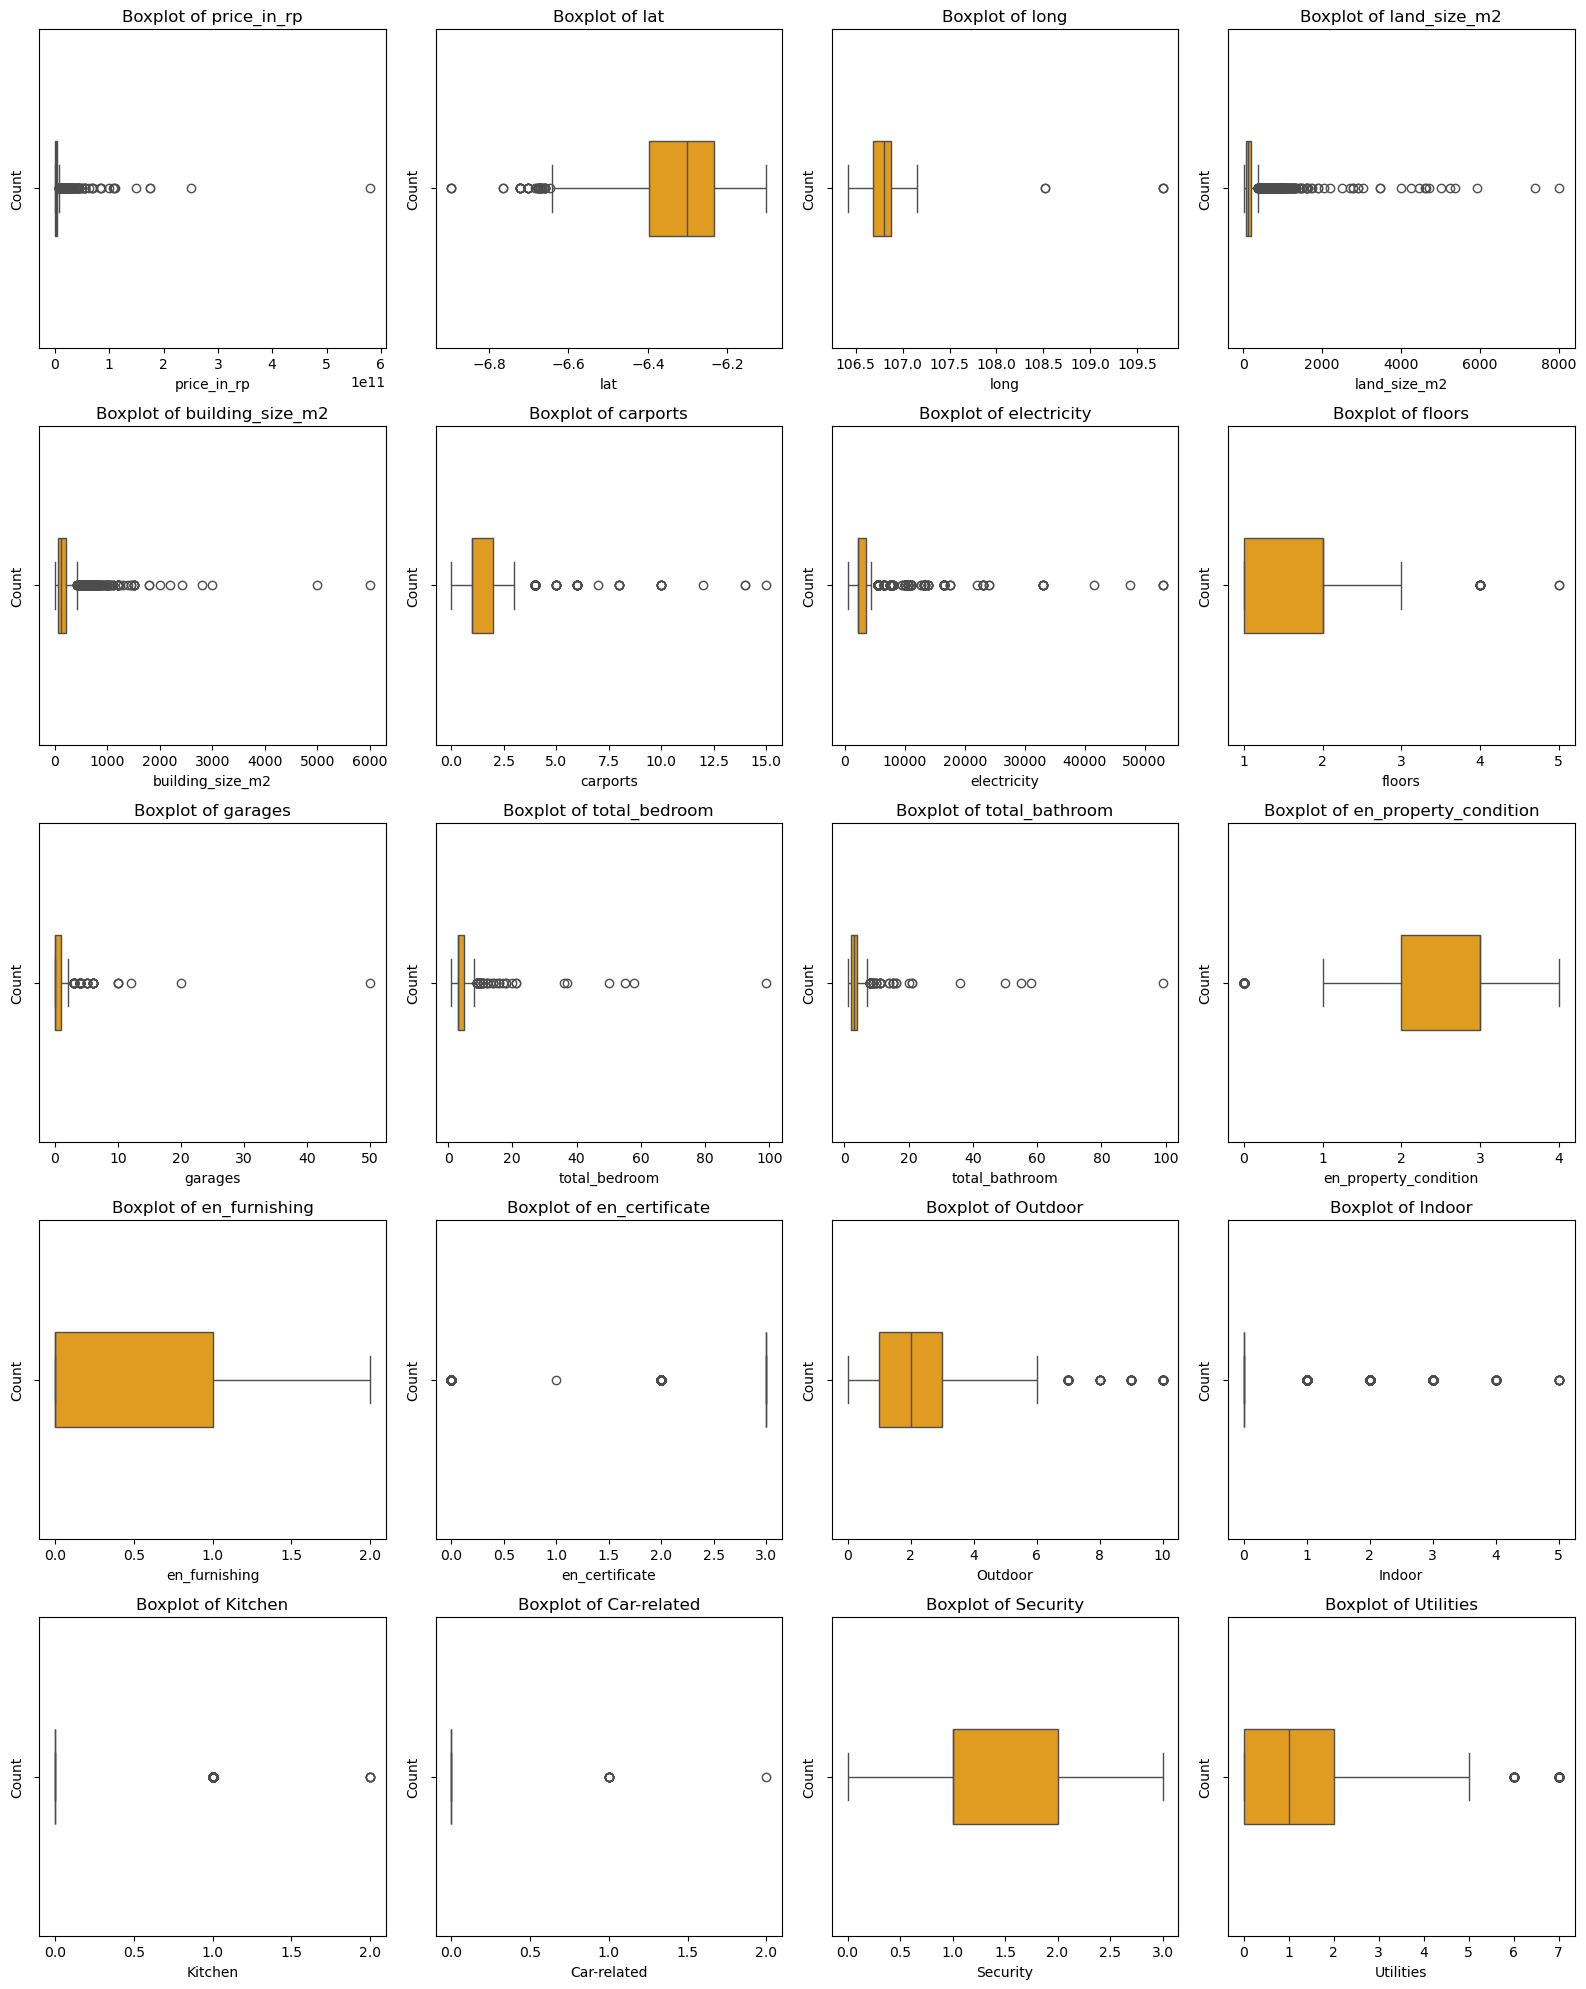

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Select numerical columns
numerical_columns = clean_df.select_dtypes(include=['int64', 'float64']).columns

# Calculate the number of rows and columns for the subplot grid
num_cols = 4
num_rows = math.ceil(len(numerical_columns) / num_cols)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 4 * num_rows))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Plot boxplots for numerical columns
for i, column in enumerate(numerical_columns):
    sns.boxplot(x=clean_df[column], ax=axes[i], color='orange', width=0.3)
    
    axes[i].set_title(f'Boxplot of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')

# Hide any empty subplots
for j in range(len(numerical_columns), len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

## Modeling

## Feature Selection For Training

In [57]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3514 entries, 0 to 3552
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_in_rp            3514 non-null   float64
 1   lat                    3514 non-null   float64
 2   long                   3514 non-null   float64
 3   land_size_m2           3514 non-null   float64
 4   building_size_m2       3514 non-null   float64
 5   carports               3514 non-null   float64
 6   electricity            3514 non-null   float64
 7   floors                 3514 non-null   float64
 8   garages                3514 non-null   float64
 9   total_bedroom          3514 non-null   float64
 10  total_bathroom         3514 non-null   float64
 11  en_property_condition  3514 non-null   int64  
 12  en_furnishing          3514 non-null   int64  
 13  en_certificate         3514 non-null   int64  
 14  Outdoor                3514 non-null   int64  
 15  Indoor   

## Regression Model

In [58]:
train_df = clean_df.copy()

## XGBOOST REGRESSION

In [59]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

# Assuming you have a DataFrame named 'clean_df' with features and target variable
# X should contain features, and y should contain the target variable

# Example data loading (replace this with your data loading code)
# clean_df = pd.read_csv('your_data.csv')
X = train_df.drop('price_in_rp', axis=1)
y = train_df['price_in_rp']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an XGBoost regressor model
model = xgb.XGBRegressor(random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model using Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error: {mae}')

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Evaluate the model using R-squared
r2 = r2_score(y_test, predictions)
print(f'R-squared: {r2}')


Mean Absolute Error: 1166047144.8762448
Mean Squared Error: 2.911460293866462e+19
R-squared: 0.5402528311380925


## Random Forest Regression

In [60]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import pandas as pd

# Assuming you have a DataFrame named 'data' with features and target variable
# X should contain features, and y should contain the target variable

# Example data loading (replace this with your data loading code)
# data = pd.read_csv('your_data.csv')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor model
model = RandomForestRegressor(random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model using Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error: {mae}')

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Evaluate the model using R-squared
r2 = r2_score(y_test, predictions)
print(f'R-squared: {r2}')

Mean Absolute Error: 929012438.2916751
Mean Squared Error: 1.4003671075987997e+19
R-squared: 0.7788687640898957


## Support Vector Regression

In [61]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

# Assuming you have a DataFrame named 'clean_df' with features and target variable
# X should contain features, and y should contain the target variable

# Example data loading (replace this with your data loading code)
# clean_df = pd.read_csv('your_data.csv')
X = clean_df.drop('price_in_rp', axis=1)
y = clean_df['price_in_rp']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an SVM regressor model
svm_model = SVR()

# Fit the model to the training data
svm_model.fit(X_train, y_train)

# Make predictions on the test set
predictions_svm = svm_model.predict(X_test)

# Evaluate the SVM model using Mean Absolute Error (MAE)
mae_svm = mean_absolute_error(y_test, predictions_svm)
print(f'SVM Mean Absolute Error: {mae_svm}')

# Evaluate the SVM model using Mean Squared Error (MSE)
mse_svm = mean_squared_error(y_test, predictions_svm)
print(f'SVM Mean Squared Error: {mse_svm}')

# Evaluate the SVM model using R-squared
r2_svm = r2_score(y_test, predictions_svm)
print(f'SVM R-squared: {r2_svm}')

SVM Mean Absolute Error: 2800459326.171667
SVM Mean Squared Error: 6.776672458226215e+19
SVM R-squared: -0.07010079565140193


## Target Binning Approach

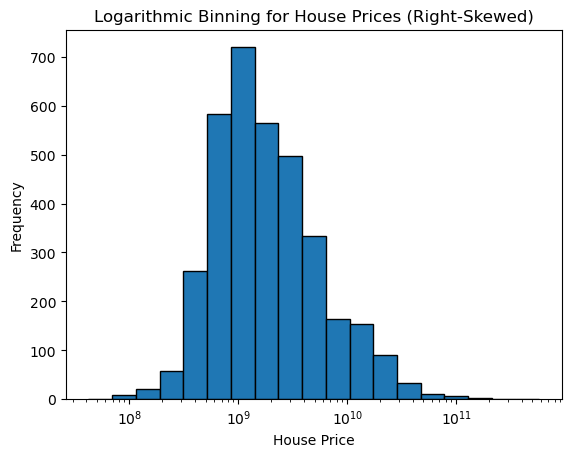

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Your data (replace this with your actual house prices)
house_prices = train_df['price_in_rp'].values
# Determine the minimum and maximum values
min_price = np.min(house_prices)
max_price = np.max(house_prices)

# Choose the number of bins (you can adjust this)
num_bins = 20

# Create a histogram with logarithmic binning
bin_edges = np.logspace(np.log10(min_price), np.log10(max_price), num_bins)
plt.hist(house_prices, bins=bin_edges, edgecolor='black')
plt.xscale('log')  # Set x-axis to logarithmic scale for better visibility
plt.xlabel('House Price')
plt.ylabel('Frequency')
plt.title('Logarithmic Binning for House Prices (Right-Skewed)')
plt.show()

<Axes: xlabel='en_price', ylabel='Density'>

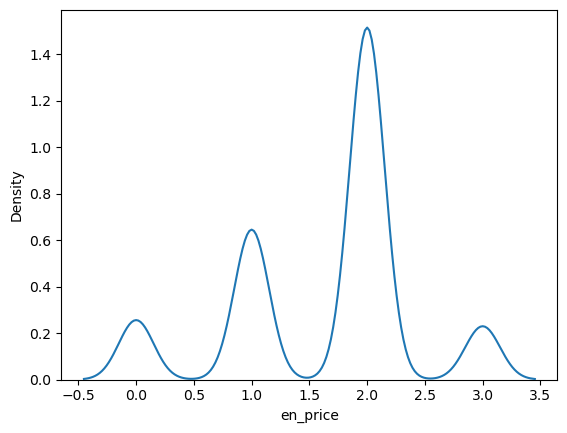

In [63]:
import numpy as np

# Replace these values with your regression output
regression_output = train_df['price_in_rp'].values

# Define your class boundaries (adjust as needed)
class_boundaries = [5e8, 1e9, 10e9]

# Create classes based on the boundaries, starting from 0
classification_output = np.digitize(regression_output, bins=class_boundaries, right=True)

train_df['en_price'] = classification_output

sns.kdeplot(train_df['en_price'])

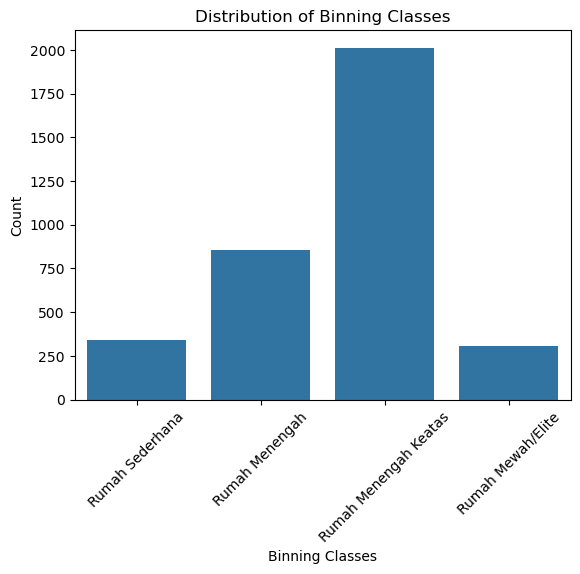

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_df already has 'en_price' column
sns.countplot(x='en_price', data=train_df)

# Map numerical labels to meaningful labels
class_labels = ['Rumah Sederhana', 'Rumah Menengah', 'Rumah Menengah Keatas', 'Rumah Mewah/Elite']
plt.xticks(ticks=[0, 1, 2, 3], labels=class_labels, rotation=45)  # Adjust the rotation angle as needed

plt.title('Distribution of Binning Classes')
plt.xlabel('Binning Classes')
plt.ylabel('Count')
plt.show()

In [65]:
train_df['en_price'].unique()

array([2, 1, 0, 3])

## Model Evaluation On Target Binning Approach

## Cross Validation using XGBClassifier, Random Forest Classifier, and SupportVectorClassifier

XGBoost Cross-Validation Scores: [0.89698046 0.87188612 0.89857651 0.86120996 0.87366548]
XGBoost Average Cross-Validation Accuracy: 0.8804637080207076
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83        69
           1       0.86      0.90      0.88       178
           2       0.96      0.95      0.96       403
           3       0.88      0.85      0.87        53

    accuracy                           0.92       703
   macro avg       0.89      0.88      0.88       703
weighted avg       0.92      0.92      0.92       703



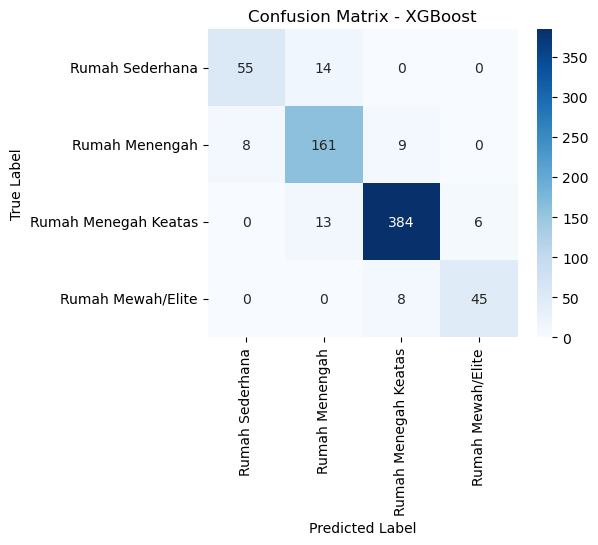

Random Forest Cross-Validation Scores: [0.89875666 0.87366548 0.88790036 0.85409253 0.86654804]
Random Forest Average Cross-Validation Accuracy: 0.8761926132879907

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.72      0.78        69
           1       0.84      0.87      0.85       178
           2       0.94      0.96      0.95       403
           3       0.90      0.81      0.85        53

    accuracy                           0.90       703
   macro avg       0.88      0.84      0.86       703
weighted avg       0.90      0.90      0.90       703



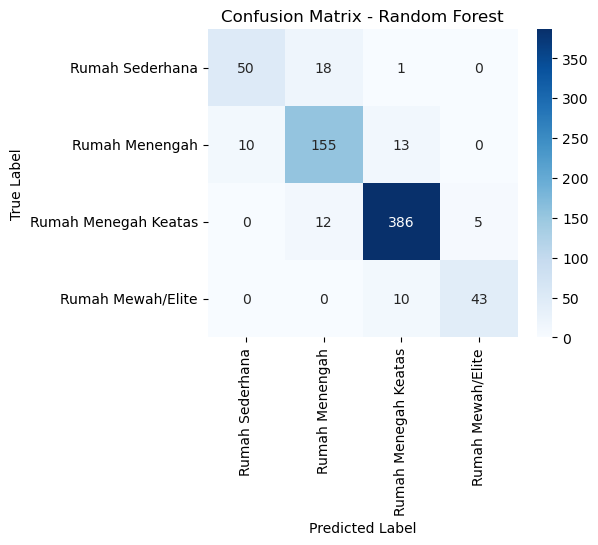

SVM Cross-Validation Scores: [0.78507993 0.77580071 0.8113879  0.7633452  0.79893238]
SVM Average Cross-Validation Accuracy: 0.7869092242245721

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.30      0.40        69
           1       0.64      0.78      0.71       178
           2       0.89      0.89      0.89       403
           3       0.78      0.72      0.75        53

    accuracy                           0.79       703
   macro avg       0.72      0.67      0.68       703
weighted avg       0.79      0.79      0.78       703



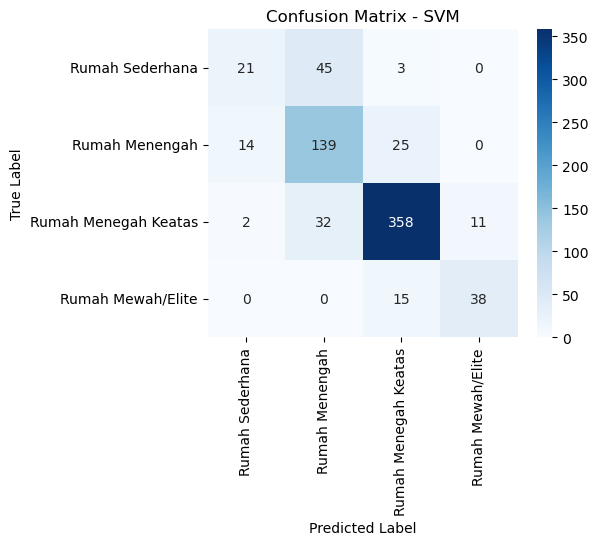

In [66]:
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Replace these values with your features and labels
X = train_df.drop(['en_price', 'price_in_rp'], axis=1)
y = train_df['en_price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42)

# Cross-validation scores for XGBoost
xgb_cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5, scoring=make_scorer(accuracy_score))
best_xgb_model_index = np.argmax(xgb_cv_scores)

# Fit the best XGBoost model on the training set
best_xgb_model = xgb_model.fit(X_train_scaled, y_train)

# Make predictions on the test set using XGBoost
y_pred_xgb = best_xgb_model.predict(X_test_scaled)

# Print the classification report for XGBoost
print("XGBoost Cross-Validation Scores:", xgb_cv_scores)
print("XGBoost Average Cross-Validation Accuracy:", np.mean(xgb_cv_scores))
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Show confusion matrix for XGBoost
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=['Rumah Sederhana', 'Rumah Menengah', 'Rumah Menegah Keatas', 'Rumah Mewah/Elite'], yticklabels=['Rumah Sederhana', 'Rumah Menengah', 'Rumah Menegah Keatas', 'Rumah Mewah/Elite'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - XGBoost")
plt.show()

# Create a Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

# Cross-validation scores for Random Forest
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring=make_scorer(accuracy_score))
best_rf_model_index = np.argmax(rf_cv_scores)

# Fit the best Random Forest model on the training set
best_rf_model = rf_model.fit(X_train, y_train)

# Make predictions on the test set using Random Forest
y_pred_rf = best_rf_model.predict(X_test)

# Print the classification report for Random Forest
print("Random Forest Cross-Validation Scores:", rf_cv_scores)
print("Random Forest Average Cross-Validation Accuracy:", np.mean(rf_cv_scores))
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Show confusion matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", xticklabels=['Rumah Sederhana', 'Rumah Menengah', 'Rumah Menegah Keatas', 'Rumah Mewah/Elite'], yticklabels=['Rumah Sederhana', 'Rumah Menengah', 'Rumah Menegah Keatas', 'Rumah Mewah/Elite'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Create an SVM classifier
svm_model = SVC(random_state=42)

# Cross-validation scores for SVM
svm_cv_scores = cross_val_score(svm_model, X_train_scaled, y_train, cv=5, scoring=make_scorer(accuracy_score))
best_svm_model_index = np.argmax(svm_cv_scores)

# Fit the best SVM model on the training set
best_svm_model = svm_model.fit(X_train_scaled, y_train)

# Make predictions on the test set using SVM
y_pred_svm = best_svm_model.predict(X_test_scaled)

# Print the classification report for SVM
print("SVM Cross-Validation Scores:", svm_cv_scores)
print("SVM Average Cross-Validation Accuracy:", np.mean(svm_cv_scores))
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Show confusion matrix for SVM
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", xticklabels=['Rumah Sederhana', 'Rumah Menengah', 'Rumah Menegah Keatas', 'Rumah Mewah/Elite'], yticklabels=['Rumah Sederhana', 'Rumah Menengah', 'Rumah Menegah Keatas', 'Rumah Mewah/Elite'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - SVM")
plt.show()

In [67]:
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_classifier(model, X_train, y_train, X_test, y_test, label):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Print classification report
    print(f"\n{label} Classification Report:\n")
    print(classification_report(y_test, y_pred))

    # Generate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Get the unique labels/categories from the true labels
    labels = np.unique(y_test)

    # Plot the confusion matrix
    display = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{label} - Confusion Matrix")
    plt.show()

## Scaling


XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.80      0.83        69
           1       0.86      0.90      0.88       178
           2       0.96      0.95      0.96       403
           3       0.88      0.85      0.87        53

    accuracy                           0.92       703
   macro avg       0.89      0.88      0.88       703
weighted avg       0.92      0.92      0.92       703



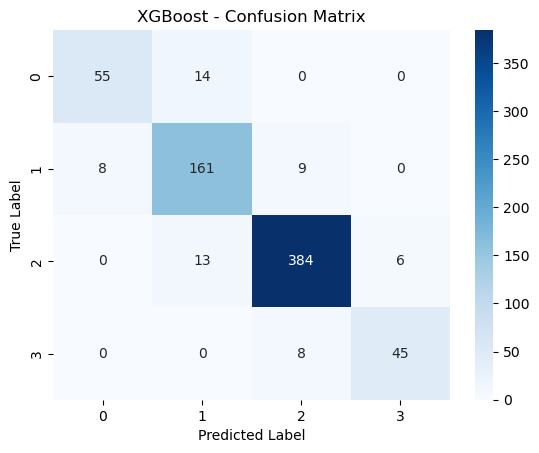


Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.72      0.78        69
           1       0.84      0.87      0.85       178
           2       0.94      0.96      0.95       403
           3       0.89      0.79      0.84        53

    accuracy                           0.90       703
   macro avg       0.88      0.84      0.85       703
weighted avg       0.90      0.90      0.90       703



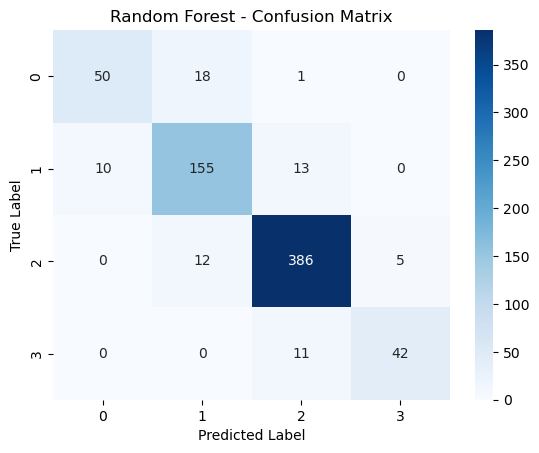


SVM Classification Report:

              precision    recall  f1-score   support

           0       0.57      0.30      0.40        69
           1       0.64      0.78      0.71       178
           2       0.89      0.89      0.89       403
           3       0.78      0.72      0.75        53

    accuracy                           0.79       703
   macro avg       0.72      0.67      0.68       703
weighted avg       0.79      0.79      0.78       703



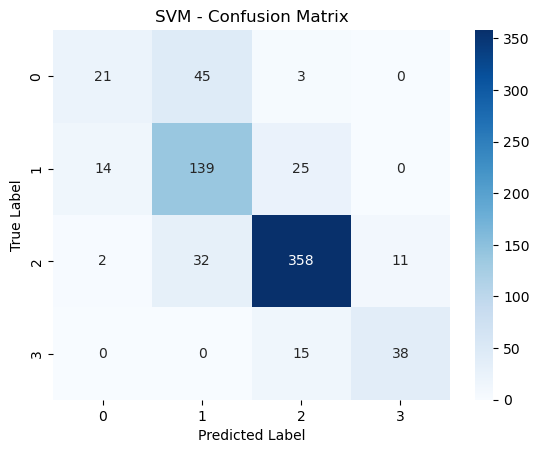

In [68]:
from sklearn.preprocessing import StandardScaler

# Assuming you have already defined your feature matrix X

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Evaluate each classifier
evaluate_classifier(xgb_model, X_train_scaled, y_train, X_test_scaled, y_test, "XGBoost")
evaluate_classifier(rf_model, X_train_scaled, y_train, X_test_scaled, y_test, "Random Forest")
evaluate_classifier(svm_model, X_train_scaled, y_train, X_test_scaled, y_test, "SVM")

## Hypertune Parameter

## XGBOOST Clasifier

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 200, 'subsample': 0.8}

XGBoost Tuned Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.72      0.76        69
           1       0.83      0.88      0.85       178
           2       0.96      0.95      0.96       403
           3       0.92      0.92      0.92        53

    accuracy                           0.91       703
   macro avg       0.88      0.87      0.87       703
weighted avg       0.91      0.91      0.91       703



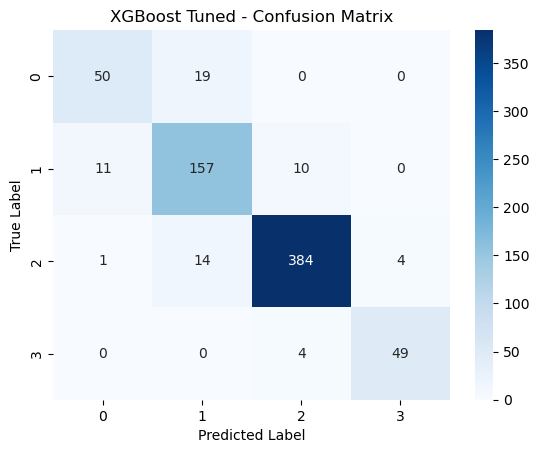

In [69]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, make_scorer
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X_train_scaled, X_test_scaled, y_train, y_test are defined
# Adjust the parameter grid as needed
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 3, 6],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_train)), random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(xgb_model, param_grid, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

# Perform grid search on the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best model for evaluation
best_xgb_model = grid_search.best_estimator_
evaluate_classifier(best_xgb_model, X_train_scaled, y_train, X_test_scaled, y_test, "XGBoost Tuned")

## Random Forest  Clasifier

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best Parameters: {'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Random Forest Tuned Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.67      0.74        69
           1       0.78      0.85      0.82       178
           2       0.93      0.94      0.94       403
           3       0.91      0.79      0.85        53

    accuracy                           0.88       703
   macro avg       0.86      0.81      0.83       703
weighted avg       0.88      0.88      0.88       703



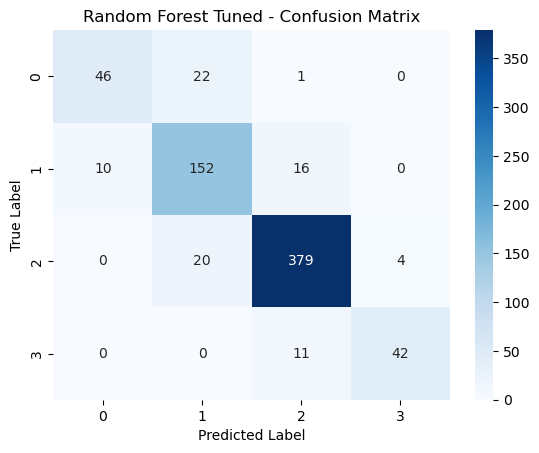

In [70]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X_train_scaled, X_test_scaled, y_train, y_test are defined
# Adjust the parameter grid as needed
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}

# Create a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(rf_model, param_grid, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

# Perform grid search on the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best model for evaluation
best_rf_model = grid_search.best_estimator_
evaluate_classifier(best_rf_model, X_train_scaled, y_train, X_test_scaled, y_test, "Random Forest Tuned")

## Support Vector  Clasifier

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best Parameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

SVM Tuned Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.55      0.57        69
           1       0.70      0.75      0.72       178
           2       0.92      0.90      0.91       403
           3       0.79      0.77      0.78        53

    accuracy                           0.82       703
   macro avg       0.75      0.74      0.75       703
weighted avg       0.82      0.82      0.82       703



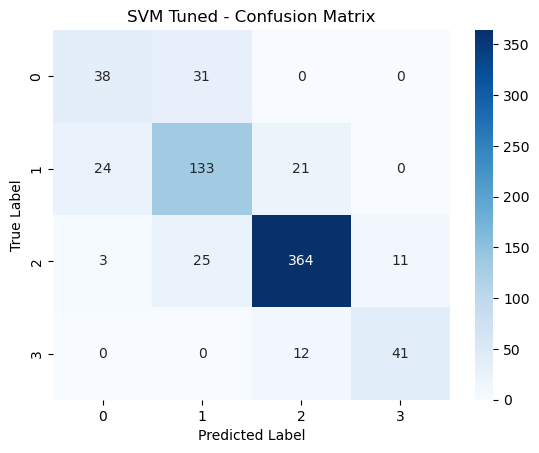

In [71]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X_train_scaled, X_test_scaled, y_train, y_test are defined
# Adjust the parameter grid as needed
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto', 0.1, 1],
}

# Create an SVM classifier
svm_model = SVC()

# Initialize GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

# Perform grid search on the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best model for evaluation
best_svm_model = grid_search.best_estimator_
evaluate_classifier(best_svm_model, X_train_scaled, y_train, X_test_scaled, y_test, "SVM Tuned")


## XGBoost Regressor (Final Model)

In [72]:

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score

xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train)

pred_xgb = xgb_model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, pred_xgb)
r2 = r2_score(y_test, pred_xgb)

print("XGBoost Regressor")
print("MAE :", mae)
print("R²  :", r2)


XGBoost Regressor
MAE : 0.15850721299648285
R²  : 0.8730473518371582


## Hyperparameter Tuning (Grid Search)

In [73]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [300, 500, 700],
    "max_depth": [5, 7, 9],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.7, 0.9]
}

xgb_tuned = xgb.XGBRegressor(random_state=42)

grid = GridSearchCV(
    estimator=xgb_tuned,
    param_grid=param_grid,
    cv=3,
    scoring="neg_mean_absolute_error",
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)

print("Best Params:", grid.best_params_)

best_xgb = grid.best_estimator_

pred_best = best_xgb.predict(X_test_scaled)

print("Tuned MAE:", mean_absolute_error(y_test, pred_best))
print("Tuned R²:", r2_score(y_test, pred_best))


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Params: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 700, 'subsample': 0.9}
Tuned MAE: 0.14600904285907745
Tuned R²: 0.8742196559906006


## Hyperparameter Tuning (RandomizedSearchCV, tanpa early stopping)

In [75]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Model dasar
xgb = XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist'
)

# Search space besar
param_dist = {
    'n_estimators': [300, 500, 700, 900, 1200, 1500, 2000],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'max_depth': [5, 7, 9, 11, 13],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.5, 1, 1.5, 2]
}

# RandomizedSearchCV tanpa early stopping
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=80,
    cv=3,
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# TUNING
random_search.fit(X_train, y_train)

print("Best Params:", random_search.best_params_)
print("Best CV R²:", random_search.best_score_)


Fitting 3 folds for each of 80 candidates, totalling 240 fits
Best Params: {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 700, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.07, 'gamma': 0, 'colsample_bytree': 0.6}
Best CV R²: 0.8224960168202718


## Fit Model Final dengan Early Stopping

In [77]:
import xgboost as xgb

# convert ke DMatrix untuk API native XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test,  label=y_test)

# ambil parameter terbaik dari RandomizedSearch
best_params = random_search.best_params_

# mapping param agar cocok dengan API XGBoost core
xgb_params = {
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'eta': best_params['learning_rate'],       # learning_rate → eta
    'max_depth': best_params['max_depth'],
    'min_child_weight': best_params['min_child_weight'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'gamma': best_params['gamma'],
    'alpha': best_params['reg_alpha'],         # reg_alpha → alpha
    'lambda': best_params['reg_lambda'],       # reg_lambda → lambda
}

# training dengan early stopping
final_model_core = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=best_params['n_estimators'],
    evals=[(dtest, 'eval')],
    early_stopping_rounds=50,
    verbose_eval=False
)

# prediksi
y_pred = final_model_core.predict(dtest)

print("Final MAE:", mean_absolute_error(y_test, y_pred))
print("Final R²:", r2_score(y_test, y_pred))


Final MAE: 0.16166892647743225
Final R²: 0.8783398270606995


## FIXED Feature Importance (versi XGBoost core)

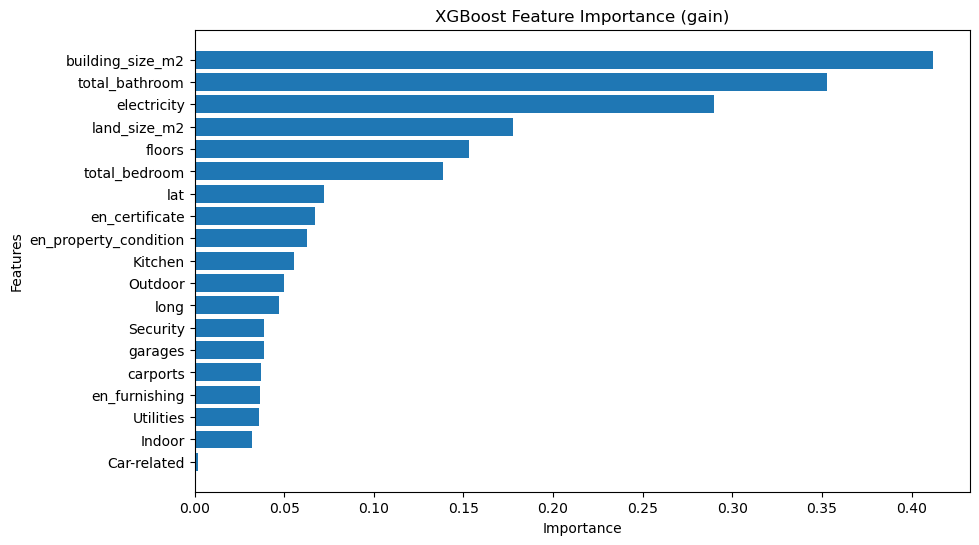

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Ambil importance dari Booster
importance_dict = final_model_core.get_score(importance_type='gain')

# Convert ke list agar bisa dipakai untuk chart
features = list(importance_dict.keys())
importance = list(importance_dict.values())

# Urutkan berdasarkan importance
sorted_idx = np.argsort(importance)
features = np.array(features)[sorted_idx]
importance = np.array(importance)[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(features, importance)
plt.title("XGBoost Feature Importance (gain)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()